<a href="https://colab.research.google.com/github/Rhodham96/GANs_CGANs/blob/main/notebooks/CGANS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CGANs - Conditional Generative Adversarial Networks

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torchvision
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torchvision.utils as vutils
import os
print(torch.__version__)

2.6.0+cu124


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean

    def __call__(self, tensor):
        noisy = tensor + torch.randn(tensor.size()) * self.std + self.mean
        return torch.clamp(noisy, 0., 1.)

    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

In [4]:
transform = transforms.Compose([
    transforms.ToTensor(),
    AddGaussianNoise(0., 0.1)
    #transforms.Normalize((0.5,), (0.5,)) # -> it is already normalized
])
# import a few images (MNIST Dataset)
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

print(f"mnist_trainset = {len(mnist_trainset)}")
print(f"mnist_testset = {len(mnist_testset)}")

100%|██████████| 9.91M/9.91M [00:01<00:00, 5.01MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 63.1kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.22MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.65MB/s]

mnist_trainset = 60000
mnist_testset = 10000


In [5]:
type(mnist_trainset[0])

tuple

In [6]:
train_image_zero, train_target_zero = mnist_trainset[0]

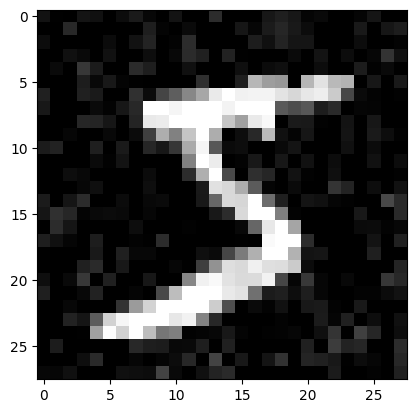

In [7]:
plt.imshow(train_image_zero.squeeze().numpy(), cmap="gray")

In [8]:
label_dim = 10

In [9]:
class Generator(nn.Module):
  def __init__(self, noise_dim=100, image_dim=784):
    super(Generator, self).__init__()
    self.label_embedding = nn.Embedding(10, label_dim)
    self.net = nn.Sequential(
        nn.Linear(noise_dim+label_dim, 256),
        #nn.BatchNorm1d(256),
        nn.ReLU(inplace=True),
        nn.Linear(256, 512),
        #nn.BatchNorm1d(512),
        nn.ReLU(inplace=True),
        nn.Linear(512, image_dim),
        nn.Tanh()
    )
  def forward(self, z, labels):
        label_emb = self.label_embedding(labels)
        z = torch.cat((z, label_emb), dim=1)  # Concaténer le bruit et le label
        return self.net(z).view(-1, 1, 28, 28)



In [10]:
class Discriminator(nn.Module):
  def __init__(self, image_dim=784):
    super(Discriminator, self).__init__()
    self.label_embedding = nn.Embedding(10, label_dim)
    self.net = nn.Sequential(
        nn.Linear(image_dim+label_dim, 256),
        nn.LeakyReLU(0.2,inplace=True),
        nn.Linear(256, 128),
        nn.LeakyReLU(0.2,inplace=True),
        nn.Linear(128,1)
    )
  def forward(self, img, labels):
        label_emb = self.label_embedding(labels)
        x = torch.cat((img.view(img.size(0), -1), label_emb), dim=1)  # Concaténer l'image et le label
        return self.net(x)


In [11]:
def weights_init_generator(m):
    if isinstance(m, nn.Linear):
        if isinstance(m, nn.Sequential): return
        nn.init.xavier_normal_(m.weight)
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)

def weights_init_discriminator(m):
    if isinstance(m, nn.Linear):
        if isinstance(m, nn.Sequential): return
        nn.init.kaiming_normal_(m.weight)
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)

In [12]:
generator = Generator()
generator.to(device)
generator.apply(weights_init_generator)
generator = torch.compile(generator)
discriminator = Discriminator()
discriminator.to(device)
discriminator.apply(weights_init_discriminator)
discriminator = torch.compile(discriminator)

# generate a batch of fake images to see if sizes are ok
z = torch.randn(64,100).to(device)
labels = torch.randint(0, 10, (64,)).to(device)
fake_images = generator(z, labels)
preds = discriminator(fake_images, labels)
print(fake_images.shape, preds.shape)


/usr/local/lib/python3.11/dist-packages/torch/_inductor/compile_fx.py:194: UserWarning: TensorFloat32 tensor cores for float32 matrix multiplication available but not enabled. Consider setting `torch.set_float32_matmul_precision('high')` for better performance.
  warnings.warn(
W0516 08:39:06.598000 1379 torch/_inductor/utils.py:1137] [0/0] Not enough SMs to use max_autotune_gemm mode


torch.Size([64, 1, 28, 28]) torch.Size([64, 1])


Epoch [1/150] | D Loss: 0.3726 | G Loss: 5.6675 | D steps: 3, G steps: 1


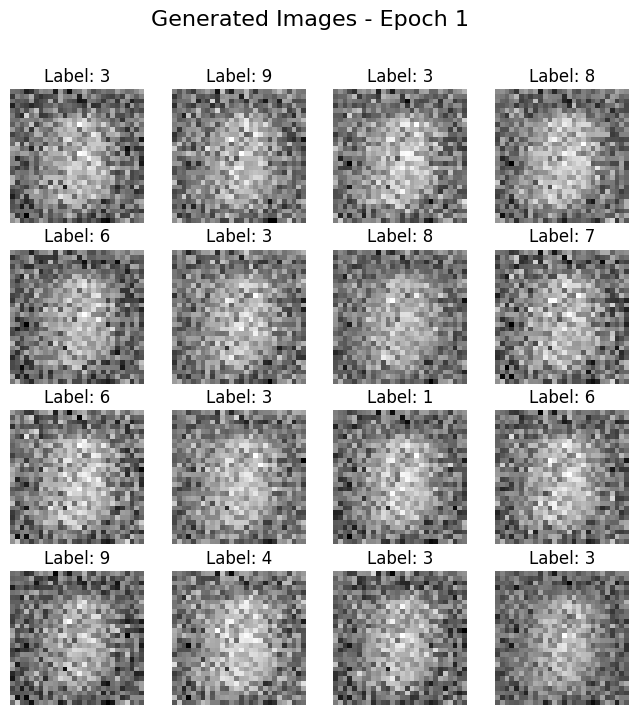

Epoch [2/150] | D Loss: 1.2884 | G Loss: 1.1186 | D steps: 1, G steps: 2
Epoch [3/150] | D Loss: 0.5212 | G Loss: 2.6621 | D steps: 3, G steps: 1
Epoch [4/150] | D Loss: 1.2612 | G Loss: 1.3346 | D steps: 1, G steps: 2
Epoch [5/150] | D Loss: 0.4524 | G Loss: 3.3581 | D steps: 3, G steps: 1
Epoch [6/150] | D Loss: 1.0800 | G Loss: 1.3431 | D steps: 1, G steps: 2
Epoch [7/150] | D Loss: 0.6890 | G Loss: 2.1543 | D steps: 1, G steps: 1
Epoch [8/150] | D Loss: 1.4679 | G Loss: 0.8375 | D steps: 1, G steps: 2
Epoch [9/150] | D Loss: 0.4686 | G Loss: 3.6056 | D steps: 3, G steps: 1
Epoch [10/150] | D Loss: 1.6530 | G Loss: 0.9916 | D steps: 1, G steps: 2
Epoch [11/150] | D Loss: 0.5016 | G Loss: 3.1288 | D steps: 3, G steps: 1


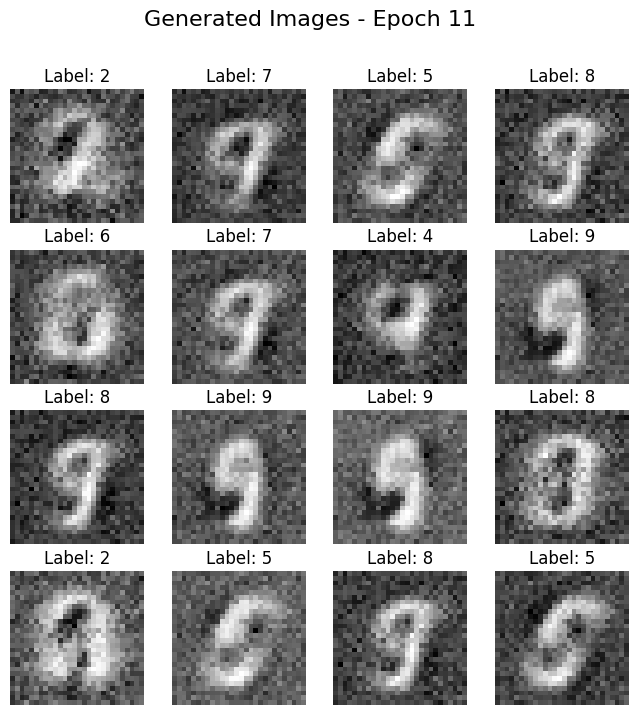

Epoch [12/150] | D Loss: 1.8423 | G Loss: 0.9957 | D steps: 1, G steps: 2
Epoch [13/150] | D Loss: 0.5081 | G Loss: 3.2366 | D steps: 3, G steps: 1
Epoch [14/150] | D Loss: 1.3391 | G Loss: 0.9266 | D steps: 1, G steps: 2
Epoch [15/150] | D Loss: 0.5513 | G Loss: 2.8971 | D steps: 3, G steps: 1
Epoch [16/150] | D Loss: 1.7513 | G Loss: 1.0510 | D steps: 1, G steps: 2
Epoch [17/150] | D Loss: 0.5051 | G Loss: 3.4385 | D steps: 3, G steps: 1
Epoch [18/150] | D Loss: 1.1187 | G Loss: 1.0624 | D steps: 1, G steps: 2
Epoch [19/150] | D Loss: 0.4673 | G Loss: 3.0940 | D steps: 3, G steps: 1
Epoch [20/150] | D Loss: 1.4266 | G Loss: 1.1826 | D steps: 1, G steps: 2
Epoch [21/150] | D Loss: 0.5375 | G Loss: 2.6580 | D steps: 3, G steps: 1


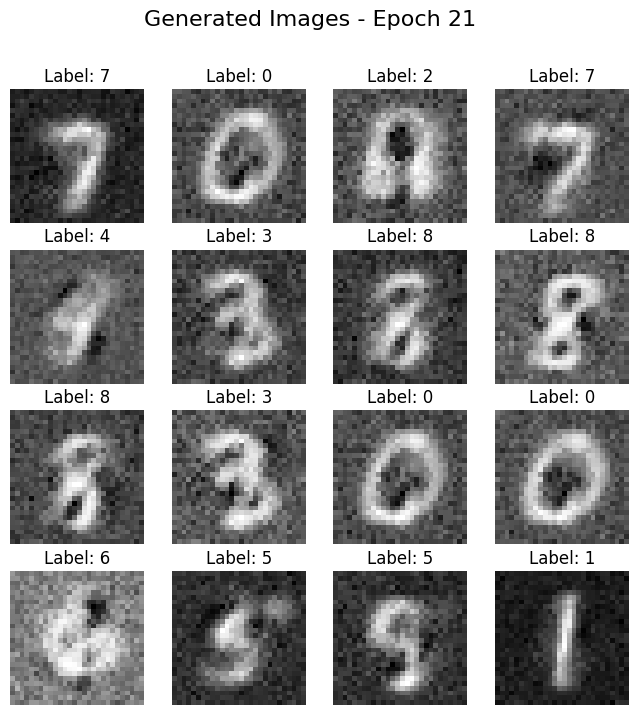

Epoch [22/150] | D Loss: 1.6331 | G Loss: 0.8264 | D steps: 1, G steps: 2
Epoch [23/150] | D Loss: 0.4863 | G Loss: 3.4226 | D steps: 3, G steps: 1
Epoch [24/150] | D Loss: 1.4258 | G Loss: 1.0348 | D steps: 1, G steps: 2
Epoch [25/150] | D Loss: 0.5002 | G Loss: 3.3128 | D steps: 3, G steps: 1
Epoch [26/150] | D Loss: 1.4654 | G Loss: 0.7454 | D steps: 1, G steps: 2
Epoch [27/150] | D Loss: 0.5508 | G Loss: 2.9446 | D steps: 3, G steps: 1
Epoch [28/150] | D Loss: 1.3822 | G Loss: 1.0638 | D steps: 1, G steps: 2
Epoch [29/150] | D Loss: 0.5225 | G Loss: 3.1122 | D steps: 3, G steps: 1
Epoch [30/150] | D Loss: 1.5041 | G Loss: 1.0840 | D steps: 1, G steps: 2
Epoch [31/150] | D Loss: 0.4408 | G Loss: 3.4696 | D steps: 3, G steps: 1


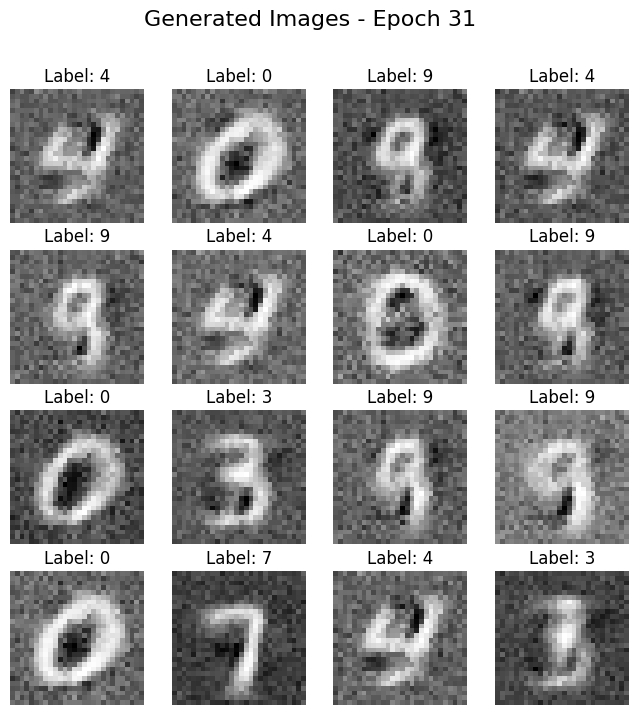

Epoch [32/150] | D Loss: 1.5321 | G Loss: 1.2091 | D steps: 1, G steps: 2
Epoch [33/150] | D Loss: 0.5366 | G Loss: 3.1850 | D steps: 3, G steps: 1
Epoch [34/150] | D Loss: 1.4779 | G Loss: 1.1460 | D steps: 1, G steps: 2
Epoch [35/150] | D Loss: 0.4428 | G Loss: 4.5557 | D steps: 3, G steps: 1
Epoch [36/150] | D Loss: 1.4264 | G Loss: 0.9478 | D steps: 1, G steps: 2
Epoch [37/150] | D Loss: 0.4833 | G Loss: 3.1772 | D steps: 3, G steps: 1
Epoch [38/150] | D Loss: 1.4979 | G Loss: 0.8911 | D steps: 1, G steps: 2
Epoch [39/150] | D Loss: 0.5084 | G Loss: 2.8704 | D steps: 3, G steps: 1
Epoch [40/150] | D Loss: 1.6483 | G Loss: 0.8182 | D steps: 1, G steps: 2
Epoch [41/150] | D Loss: 0.5045 | G Loss: 3.2373 | D steps: 3, G steps: 1


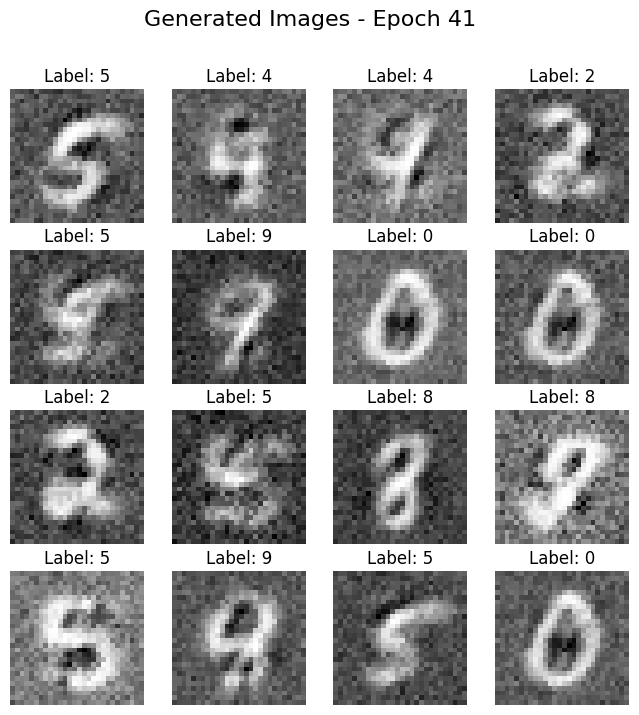

Epoch [42/150] | D Loss: 1.4655 | G Loss: 0.8788 | D steps: 1, G steps: 2
Epoch [43/150] | D Loss: 0.4834 | G Loss: 3.7920 | D steps: 3, G steps: 1
Epoch [44/150] | D Loss: 1.2839 | G Loss: 0.9437 | D steps: 1, G steps: 2
Epoch [45/150] | D Loss: 0.5561 | G Loss: 3.2439 | D steps: 3, G steps: 1
Epoch [46/150] | D Loss: 1.5093 | G Loss: 1.1217 | D steps: 1, G steps: 2
Epoch [47/150] | D Loss: 0.4625 | G Loss: 3.6306 | D steps: 3, G steps: 1
Epoch [48/150] | D Loss: 1.4693 | G Loss: 1.0643 | D steps: 1, G steps: 2
Epoch [49/150] | D Loss: 0.5474 | G Loss: 3.2727 | D steps: 3, G steps: 1
Epoch [50/150] | D Loss: 1.3039 | G Loss: 1.0485 | D steps: 1, G steps: 2
Epoch [51/150] | D Loss: 0.4875 | G Loss: 3.5910 | D steps: 3, G steps: 1


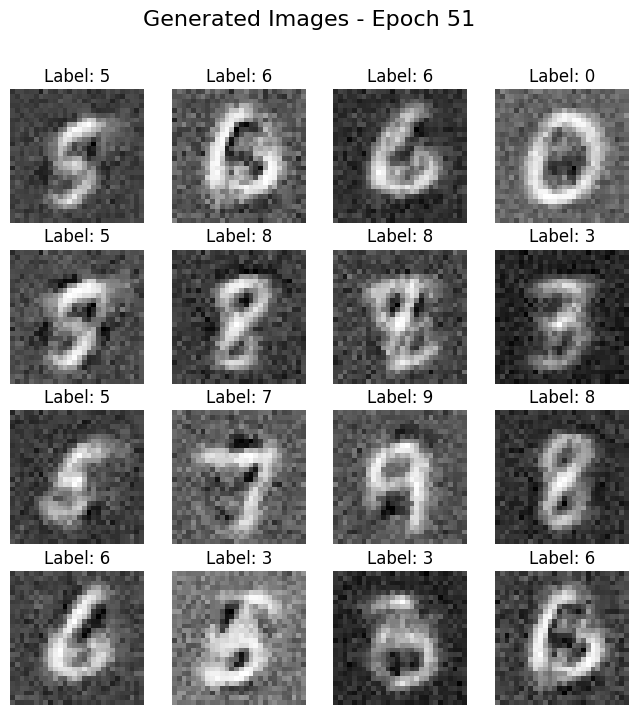

Epoch [52/150] | D Loss: 1.4963 | G Loss: 1.1781 | D steps: 1, G steps: 2
Epoch [53/150] | D Loss: 0.5800 | G Loss: 2.9478 | D steps: 3, G steps: 1
Epoch [54/150] | D Loss: 1.4179 | G Loss: 0.9925 | D steps: 1, G steps: 2
Epoch [55/150] | D Loss: 0.4990 | G Loss: 3.4242 | D steps: 3, G steps: 1
Epoch [56/150] | D Loss: 1.3309 | G Loss: 1.0141 | D steps: 1, G steps: 2
Epoch [57/150] | D Loss: 0.5469 | G Loss: 3.4377 | D steps: 3, G steps: 1
Epoch [58/150] | D Loss: 1.4497 | G Loss: 1.3528 | D steps: 1, G steps: 2
Epoch [59/150] | D Loss: 0.5135 | G Loss: 3.1359 | D steps: 3, G steps: 1
Epoch [60/150] | D Loss: 1.3251 | G Loss: 0.9449 | D steps: 1, G steps: 2
Epoch [61/150] | D Loss: 0.6042 | G Loss: 3.0941 | D steps: 3, G steps: 1


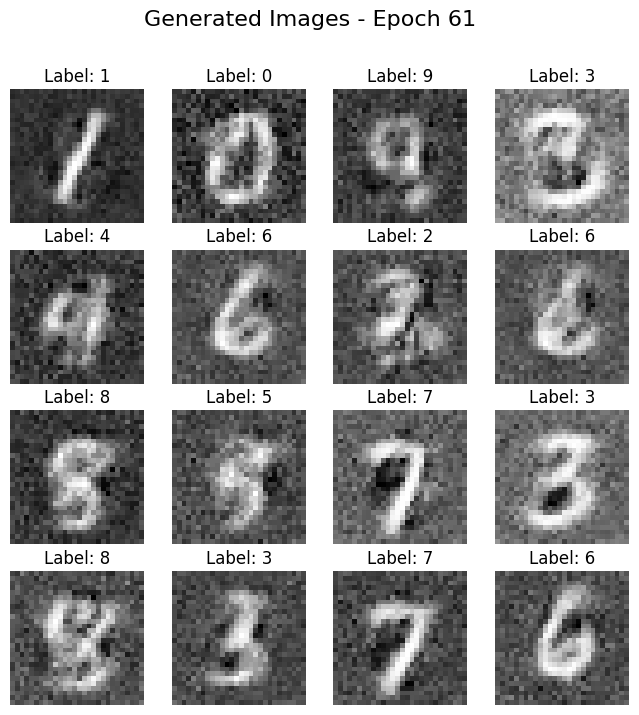

Epoch [62/150] | D Loss: 1.9811 | G Loss: 1.0562 | D steps: 1, G steps: 2
Epoch [63/150] | D Loss: 0.5675 | G Loss: 3.3325 | D steps: 3, G steps: 1
Epoch [64/150] | D Loss: 1.4805 | G Loss: 1.5347 | D steps: 1, G steps: 2
Epoch [65/150] | D Loss: 0.5420 | G Loss: 3.2907 | D steps: 3, G steps: 1
Epoch [66/150] | D Loss: 1.3743 | G Loss: 1.0778 | D steps: 1, G steps: 2
Epoch [67/150] | D Loss: 0.5041 | G Loss: 3.5077 | D steps: 3, G steps: 1
Epoch [68/150] | D Loss: 1.5708 | G Loss: 0.8910 | D steps: 1, G steps: 2
Epoch [69/150] | D Loss: 0.5280 | G Loss: 2.5657 | D steps: 3, G steps: 1
Epoch [70/150] | D Loss: 1.3293 | G Loss: 0.9420 | D steps: 1, G steps: 2
Epoch [71/150] | D Loss: 0.5646 | G Loss: 2.8920 | D steps: 3, G steps: 1


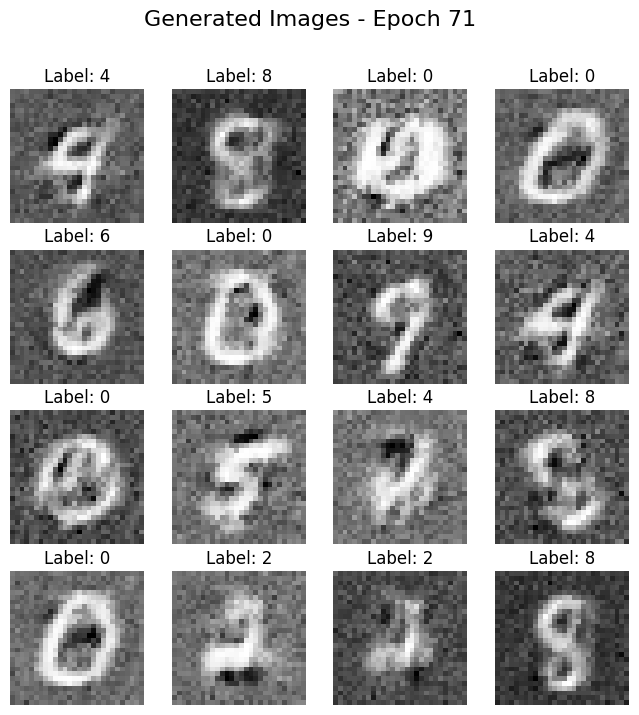

Epoch [72/150] | D Loss: 1.3887 | G Loss: 1.0071 | D steps: 1, G steps: 2
Epoch [73/150] | D Loss: 0.4957 | G Loss: 4.5677 | D steps: 3, G steps: 1
Epoch [74/150] | D Loss: 1.5761 | G Loss: 1.2627 | D steps: 1, G steps: 2
Epoch [75/150] | D Loss: 0.5547 | G Loss: 2.9786 | D steps: 3, G steps: 1
Epoch [76/150] | D Loss: 1.2739 | G Loss: 1.0758 | D steps: 1, G steps: 2
Epoch [77/150] | D Loss: 0.5311 | G Loss: 3.8093 | D steps: 3, G steps: 1
Epoch [78/150] | D Loss: 1.6094 | G Loss: 1.0884 | D steps: 1, G steps: 2
Epoch [79/150] | D Loss: 0.5215 | G Loss: 3.6890 | D steps: 3, G steps: 1
Epoch [80/150] | D Loss: 1.5597 | G Loss: 1.1856 | D steps: 1, G steps: 2
Epoch [81/150] | D Loss: 0.5769 | G Loss: 2.8369 | D steps: 3, G steps: 1


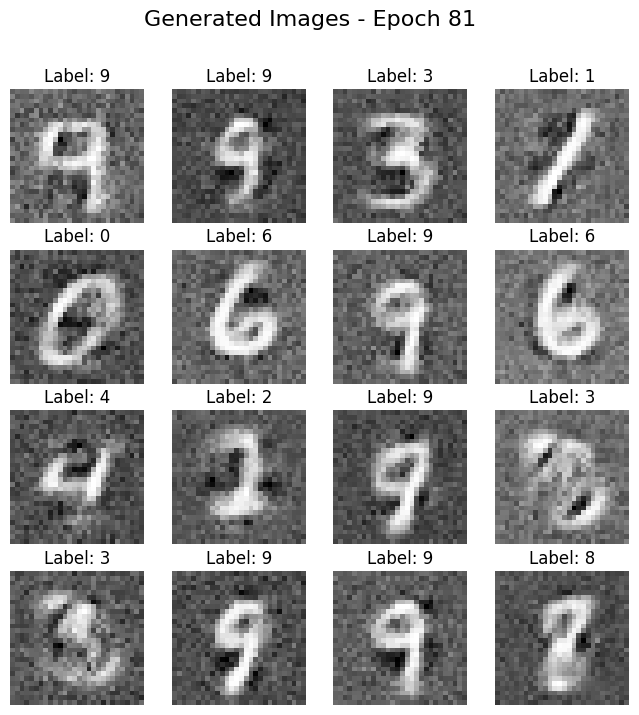

Epoch [82/150] | D Loss: 1.4514 | G Loss: 0.9582 | D steps: 1, G steps: 2
Epoch [83/150] | D Loss: 0.5200 | G Loss: 3.4118 | D steps: 3, G steps: 1
Epoch [84/150] | D Loss: 1.2673 | G Loss: 1.0299 | D steps: 1, G steps: 2
Epoch [85/150] | D Loss: 0.5686 | G Loss: 3.6652 | D steps: 3, G steps: 1
Epoch [86/150] | D Loss: 1.3952 | G Loss: 1.2008 | D steps: 1, G steps: 2
Epoch [87/150] | D Loss: 0.5057 | G Loss: 3.2247 | D steps: 3, G steps: 1
Epoch [88/150] | D Loss: 1.4962 | G Loss: 1.0916 | D steps: 1, G steps: 2
Epoch [89/150] | D Loss: 0.4903 | G Loss: 3.3999 | D steps: 3, G steps: 1
Epoch [90/150] | D Loss: 1.3205 | G Loss: 1.1838 | D steps: 1, G steps: 2
Epoch [91/150] | D Loss: 0.5320 | G Loss: 3.4876 | D steps: 3, G steps: 1


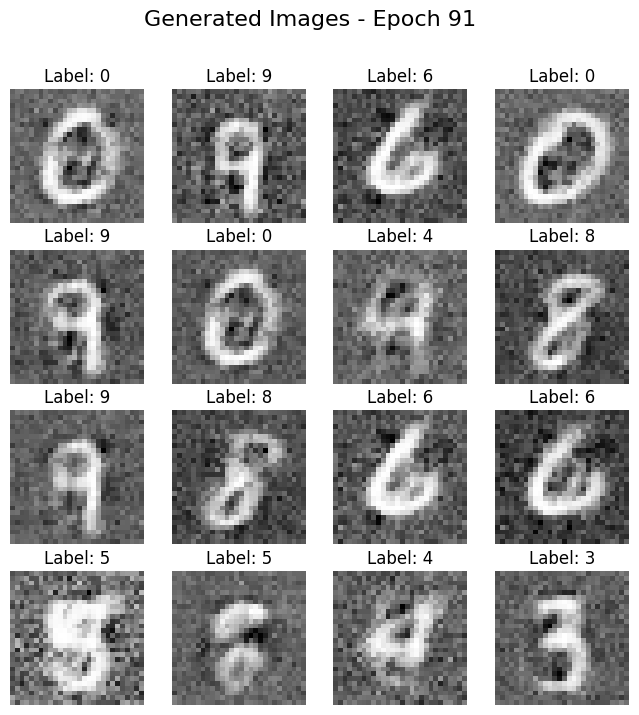

Epoch [92/150] | D Loss: 1.5175 | G Loss: 1.3590 | D steps: 1, G steps: 2
Epoch [93/150] | D Loss: 0.5845 | G Loss: 3.0606 | D steps: 3, G steps: 1
Epoch [94/150] | D Loss: 1.3627 | G Loss: 1.0628 | D steps: 1, G steps: 2
Epoch [95/150] | D Loss: 0.5390 | G Loss: 3.5334 | D steps: 3, G steps: 1
Epoch [96/150] | D Loss: 1.8913 | G Loss: 0.9807 | D steps: 1, G steps: 2
Epoch [97/150] | D Loss: 0.5287 | G Loss: 2.8336 | D steps: 3, G steps: 1
Epoch [98/150] | D Loss: 1.4824 | G Loss: 1.2264 | D steps: 1, G steps: 2
Epoch [99/150] | D Loss: 0.5257 | G Loss: 3.4121 | D steps: 3, G steps: 1
Epoch [100/150] | D Loss: 1.3027 | G Loss: 1.0724 | D steps: 1, G steps: 2
Epoch [101/150] | D Loss: 0.6304 | G Loss: 2.5954 | D steps: 3, G steps: 1


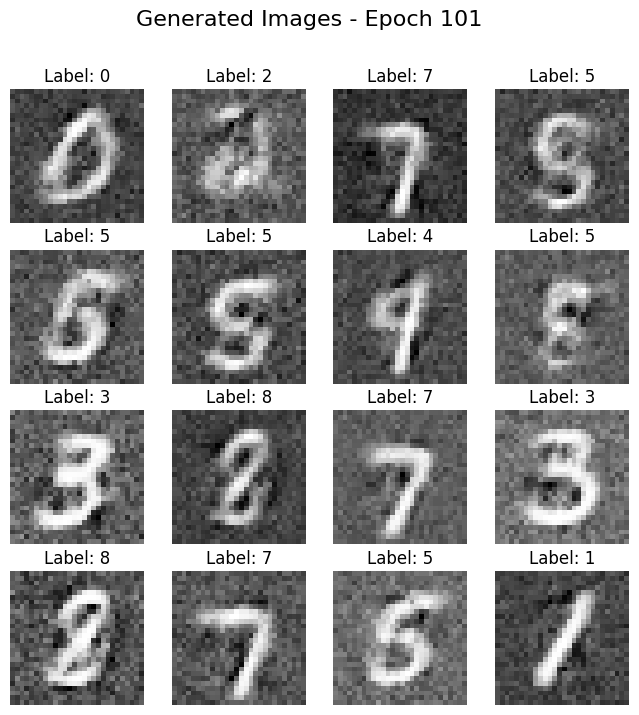

Epoch [102/150] | D Loss: 1.5525 | G Loss: 1.4201 | D steps: 1, G steps: 2
Epoch [103/150] | D Loss: 0.5091 | G Loss: 3.6832 | D steps: 3, G steps: 1
Epoch [104/150] | D Loss: 1.0770 | G Loss: 1.3512 | D steps: 1, G steps: 2
Epoch [105/150] | D Loss: 1.1329 | G Loss: 1.2569 | D steps: 1, G steps: 1
Epoch [106/150] | D Loss: 0.5481 | G Loss: 3.1420 | D steps: 3, G steps: 1
Epoch [107/150] | D Loss: 1.2585 | G Loss: 1.1694 | D steps: 1, G steps: 2
Epoch [108/150] | D Loss: 0.5307 | G Loss: 3.0454 | D steps: 3, G steps: 1
Epoch [109/150] | D Loss: 1.5456 | G Loss: 1.5872 | D steps: 1, G steps: 2
Epoch [110/150] | D Loss: 0.6002 | G Loss: 3.2599 | D steps: 3, G steps: 1
Epoch [111/150] | D Loss: 1.5616 | G Loss: 1.0897 | D steps: 1, G steps: 2


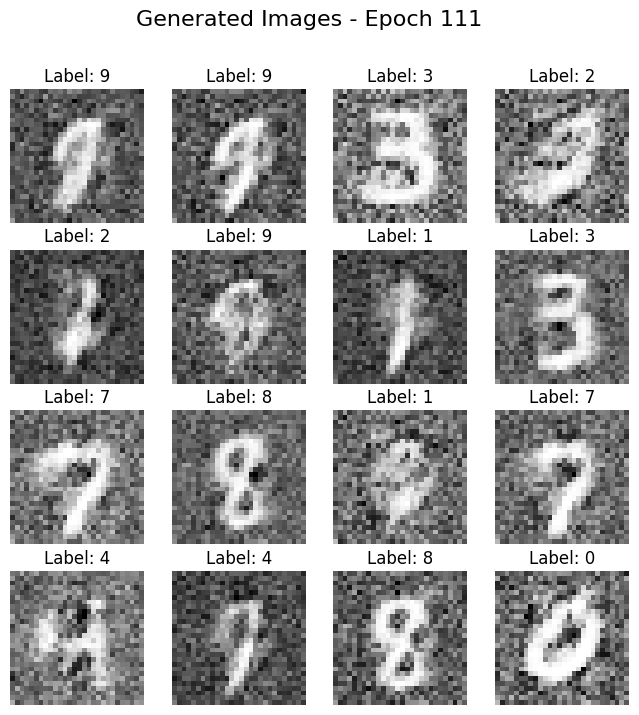

Epoch [112/150] | D Loss: 0.5699 | G Loss: 3.0790 | D steps: 3, G steps: 1
Epoch [113/150] | D Loss: 1.4160 | G Loss: 1.0377 | D steps: 1, G steps: 2
Epoch [114/150] | D Loss: 0.6352 | G Loss: 2.8230 | D steps: 3, G steps: 1
Epoch [115/150] | D Loss: 1.4269 | G Loss: 1.0455 | D steps: 1, G steps: 2
Epoch [116/150] | D Loss: 0.5719 | G Loss: 2.9167 | D steps: 3, G steps: 1
Epoch [117/150] | D Loss: 1.3018 | G Loss: 1.1571 | D steps: 1, G steps: 2
Epoch [118/150] | D Loss: 0.5492 | G Loss: 3.4132 | D steps: 3, G steps: 1
Epoch [119/150] | D Loss: 1.4956 | G Loss: 0.9779 | D steps: 1, G steps: 2
Epoch [120/150] | D Loss: 0.5781 | G Loss: 2.9906 | D steps: 3, G steps: 1
Epoch [121/150] | D Loss: 1.7343 | G Loss: 1.1489 | D steps: 1, G steps: 2


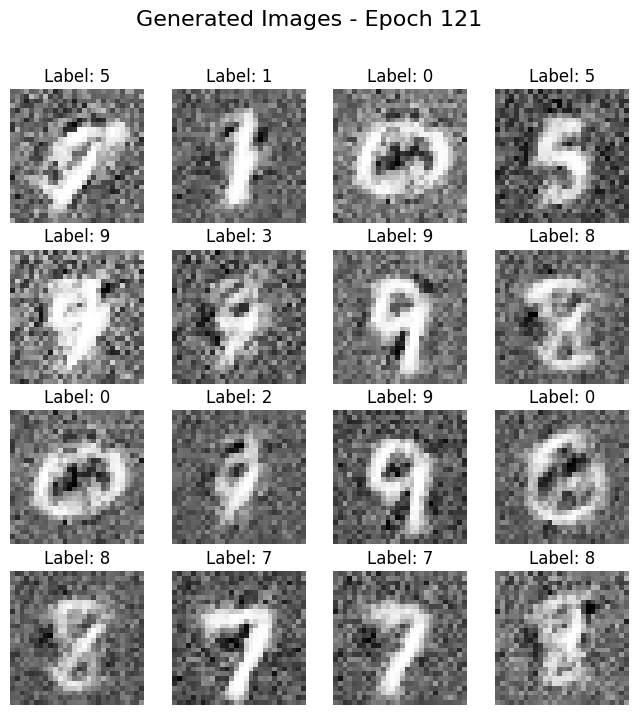

Epoch [122/150] | D Loss: 0.6568 | G Loss: 2.9074 | D steps: 3, G steps: 1
Epoch [123/150] | D Loss: 1.2103 | G Loss: 1.2672 | D steps: 1, G steps: 2
Epoch [124/150] | D Loss: 0.5922 | G Loss: 4.0253 | D steps: 3, G steps: 1
Epoch [125/150] | D Loss: 1.5728 | G Loss: 0.9003 | D steps: 1, G steps: 2
Epoch [126/150] | D Loss: 0.6547 | G Loss: 2.6638 | D steps: 3, G steps: 1
Epoch [127/150] | D Loss: 1.1033 | G Loss: 1.6269 | D steps: 1, G steps: 2
Epoch [128/150] | D Loss: 0.6508 | G Loss: 2.8436 | D steps: 3, G steps: 1
Epoch [129/150] | D Loss: 1.4769 | G Loss: 1.0345 | D steps: 1, G steps: 2
Epoch [130/150] | D Loss: 0.4827 | G Loss: 3.1596 | D steps: 3, G steps: 1
Epoch [131/150] | D Loss: 1.8252 | G Loss: 1.1333 | D steps: 1, G steps: 2


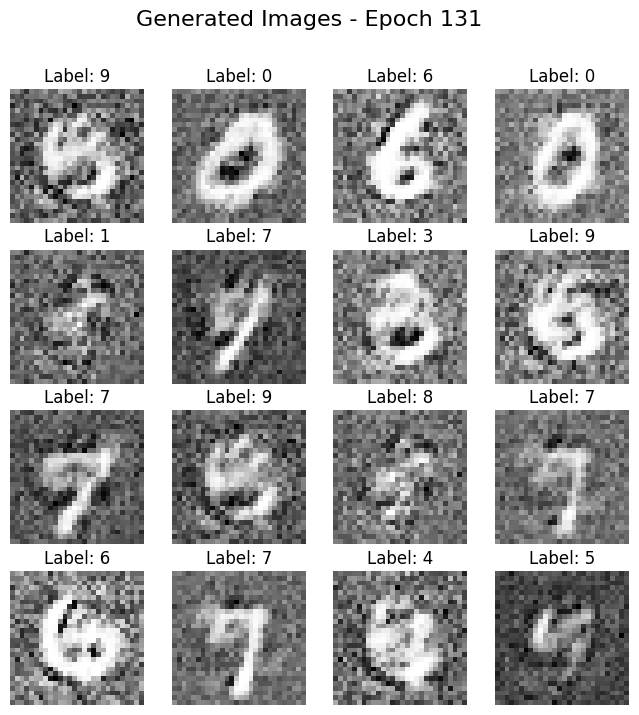

Epoch [132/150] | D Loss: 0.6155 | G Loss: 2.7098 | D steps: 3, G steps: 1
Epoch [133/150] | D Loss: 1.4475 | G Loss: 1.2375 | D steps: 1, G steps: 2
Epoch [134/150] | D Loss: 0.5968 | G Loss: 2.8929 | D steps: 3, G steps: 1
Epoch [135/150] | D Loss: 1.5008 | G Loss: 1.0319 | D steps: 1, G steps: 2
Epoch [136/150] | D Loss: 0.7064 | G Loss: 2.5686 | D steps: 3, G steps: 1
Epoch [137/150] | D Loss: 1.0336 | G Loss: 1.7210 | D steps: 1, G steps: 1
Epoch [138/150] | D Loss: 1.0391 | G Loss: 1.5294 | D steps: 1, G steps: 1
Epoch [139/150] | D Loss: 0.9593 | G Loss: 1.9657 | D steps: 1, G steps: 1
Epoch [140/150] | D Loss: 1.1071 | G Loss: 1.2803 | D steps: 1, G steps: 1
Epoch [141/150] | D Loss: 0.5955 | G Loss: 2.5102 | D steps: 3, G steps: 1


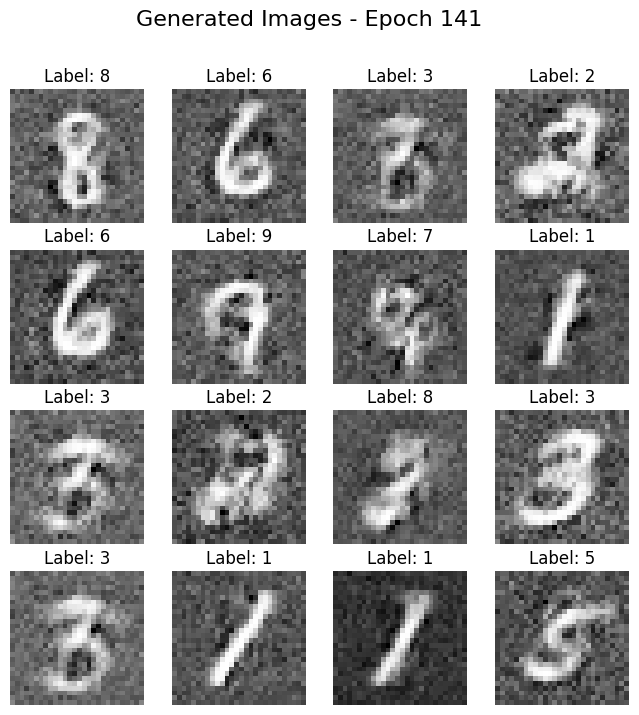

Epoch [142/150] | D Loss: 2.0414 | G Loss: 1.5082 | D steps: 1, G steps: 2
Epoch [143/150] | D Loss: 0.6572 | G Loss: 2.3197 | D steps: 3, G steps: 1
Epoch [144/150] | D Loss: 1.4340 | G Loss: 1.1626 | D steps: 1, G steps: 2
Epoch [145/150] | D Loss: 0.6055 | G Loss: 2.5396 | D steps: 3, G steps: 1
Epoch [146/150] | D Loss: 1.3924 | G Loss: 1.0352 | D steps: 1, G steps: 2
Epoch [147/150] | D Loss: 0.7221 | G Loss: 2.2444 | D steps: 3, G steps: 1
Epoch [148/150] | D Loss: 0.9414 | G Loss: 1.7348 | D steps: 1, G steps: 1
Epoch [149/150] | D Loss: 0.9249 | G Loss: 1.4492 | D steps: 1, G steps: 1
Epoch [150/150] | D Loss: 1.0915 | G Loss: 1.4196 | D steps: 1, G steps: 1


In [13]:
batch_size = 128
image_dim = 784
noise_dim = 100

train_dataloader = torch.utils.data.DataLoader(
    mnist_trainset,
    batch_size=batch_size,
    shuffle=True,
    pin_memory=True,
    num_workers=4
)
g_optimizer = torch.optim.Adam(generator.parameters(), lr=2e-4)
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=2e-4)
loss_fn = nn.BCEWithLogitsLoss()
torch.optim.lr_scheduler.StepLR(g_optimizer, step_size=50, gamma=0.5)
torch.optim.lr_scheduler.StepLR(d_optimizer, step_size=50, gamma=0.5)

os.makedirs('generated_images', exist_ok=True)

d_losses = []
g_losses = []

best_g_loss = float("inf")

#treshold = 30
num_epochs = 150
fixed_noise = torch.randn(1, noise_dim).to(device)
for epoch in range(num_epochs):
  if len(d_losses) > 0:
    last_d_loss = d_losses[-1]

    if last_d_loss < 0.7:
        d_steps = 1
        g_steps = 2
    elif last_d_loss > 1.1:
        d_steps = 3
        g_steps = 1
    else:
        d_steps = 1
        g_steps = 1
  else:
    d_steps = 3
    g_steps = 1  # pour bien initier D au départ
  #d_steps = 1
  #g_steps = 1

  generator.train()
  for real_images, labels in train_dataloader:
    batch_size = real_images.size(0)
    real_images = real_images.view(batch_size, -1).to(device)
    labels = labels.to(device)

    ## Train discriminator
    for _ in range(d_steps):
      # Génération de bruit aléatoire
      noise = torch.randn(batch_size, noise_dim).to(device)
      fake_labels_generated = torch.randint(0, 10, (batch_size,)).to(device)  # labels pour les images générées
      fake_images = generator(noise, fake_labels_generated)

      # Labels pour les vraies images et les fausses images
      real_labels = torch.full((batch_size, 1), 0.9, device=device).float()  # Labels des vraies images (proches de 1)
      fake_labels_real = torch.full((batch_size, 1), 0.0, device=device).float()  # Labels des fausses images (proches de 0)

      # Sorties du discriminateur
      outputs_fake = discriminator(fake_images.detach(), fake_labels_generated)  # Utiliser fake_labels pour les images générées
      outputs_real = discriminator(real_images, labels)  # Utiliser real_labels pour les vraies images

      # Calcul des pertes
      d_loss_fake = loss_fn(outputs_fake, fake_labels_real)  # Comparer les sorties pour les fausses images
      d_loss_real = loss_fn(outputs_real, real_labels)  # Comparer les sorties pour les vraies images
      d_loss = d_loss_fake + d_loss_real

      if d_loss.item() >= 0.1:
        d_optimizer.zero_grad()
        d_loss.backward()
        d_optimizer.step()
      else:
        print("Discriminator too strong, skipping D step this batch.")

    ## Train generator
    for _ in range(g_steps):
      noise = torch.randn(batch_size, noise_dim).to(device)
      random_labels = torch.randint(0, 10, (batch_size,)).to(device)
      fake_images = generator(noise, random_labels)
      outputs = discriminator(fake_images, random_labels)

      real_labels_g = torch.rand(batch_size, 1) * 0.1 + 0.9
      real_labels_g = real_labels_g.to(device)

      g_loss = loss_fn(outputs, real_labels_g)

      # backpropagation
      g_optimizer.zero_grad()
      g_loss.backward()

      if g_loss.item() < best_g_loss:
        best_g_loss = g_loss.item()
        torch.save(generator.state_dict(), "best_generator.pth")

      g_optimizer.step()

  d_losses.append(d_loss.item())
  g_losses.append(g_loss.item())
  print(f"Epoch [{epoch+1}/{num_epochs}] | D Loss: {d_loss.item():.4f} | G Loss: {g_loss.item():.4f} | D steps: {d_steps}, G steps: {g_steps}")

  if epoch%10 == 0 or epoch == 0:
    with torch.no_grad():
      generator.eval()
      sample_noise = torch.randn(16, noise_dim).to(device)
      test_labels = torch.randint(0, 10, (16,)).to(device)
      fake_batch = generator(sample_noise, test_labels)
      fake_batch = fake_batch.view(-1, 1, 28, 28)  # (B, C, H, W)
      fake_batch = (fake_batch + 1) / 2  # remettre entre 0 et 1 si tanh utilisé

      plt.figure(figsize=(8,8))
      plt.suptitle(f"Generated Images - Epoch {epoch+1}", fontsize=16)
      for i in range(fake_batch.size(0)):
        plt.subplot(4, 4, i+1)  # 4x4 grid pour 16 images
        plt.imshow(fake_batch[i].cpu().squeeze(), cmap='gray')
        plt.title(f"Label: {test_labels[i].item()}")  # Afficher le label au-dessus de chaque image
        plt.axis('off')
      plt.show()
      generator.train()


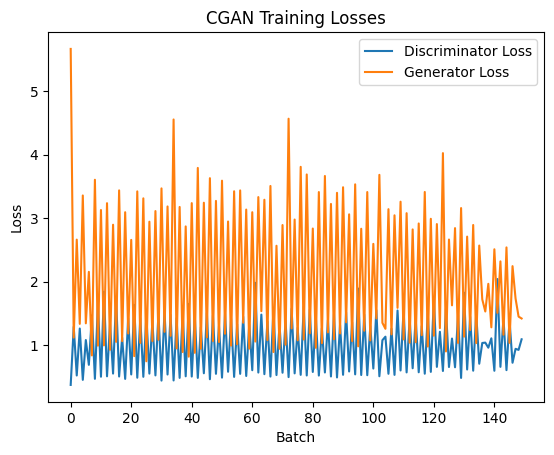

In [14]:
plt.plot(np.array(d_losses), label="Discriminator Loss")
plt.plot(np.array(g_losses), label="Generator Loss")
plt.legend()
plt.title("CGAN Training Losses")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.show()

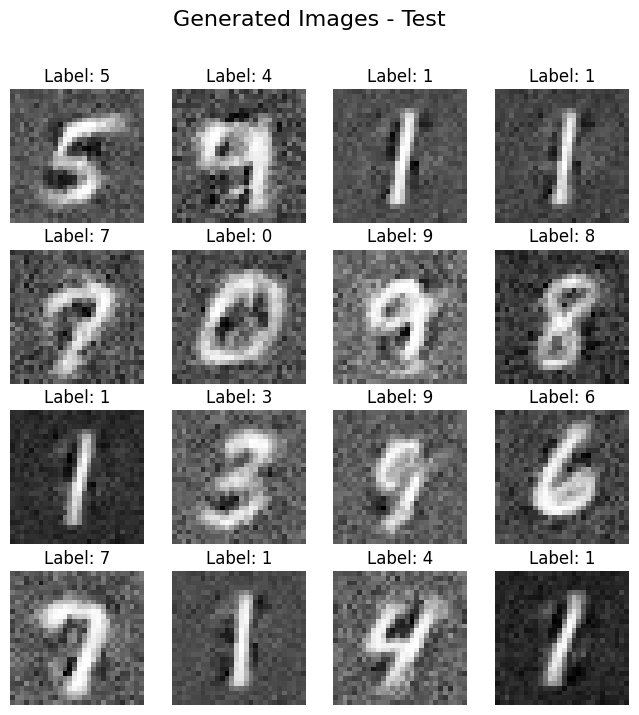

In [19]:
# Test
generator_test = Generator()
generator.load_state_dict(torch.load("best_generator.pth"))
generator.eval()

sample_noise = torch.randn(16, noise_dim).to(device)
test_labels = torch.randint(0, 10, (16,)).to(device)
fake_batch = generator(sample_noise, test_labels)
fake_batch = fake_batch.view(-1, 1, 28, 28)  # (B, C, H, W)
fake_batch = (fake_batch + 1) / 2  # remettre entre 0 et 1 si tanh utilisé

plt.figure(figsize=(8,8))
plt.suptitle(f"Generated Images - Test", fontsize=16)
for i in range(fake_batch.size(0)):
  plt.subplot(4, 4, i+1)  # 4x4 grid pour 16 images
  plt.imshow(fake_batch[i].detach().cpu().squeeze(), cmap='gray')
  plt.title(f"Label: {test_labels[i].item()}")  # Afficher le label au-dessus de chaque image
  plt.axis('off')
plt.show()
